In [85]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [92]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, BaseMessage
import os
from pydantic import BaseModel, Field
import operator
from langgraph.checkpoint.memory import MemorySaver

from langgraph_supervisor import create_supervisor
from langchain.agents import create_agent
model = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)

# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

def find_age_tool(query : str) -> str :
    """verify the age """
    return (
        "here are the ages of 3 people \n"
        "1. **ram** : 23 years\n"
        "2. **rahul**: 43 years\n"
        "3. **riya**: 33 years"
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

find_age_agent = create_react_agent(
    model = model,
    tools = [find_age_tool],
    name = "find_age_expert",
    prompt = "you are agent with access to people with ages"
)





C:\Users\Shubro\AppData\Local\Temp\ipykernel_5128\412928715.py:50: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent = create_react_agent(
C:\Users\Shubro\AppData\Local\Temp\ipykernel_5128\412928715.py:57: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(
C:\Users\Shubro\AppData\Local\Temp\ipykernel_5128\412928715.py:64: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  find_age_agent = create_react_agent(


In [93]:
workflow = create_supervisor(
    [research_agent, math_agent, find_age_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert and a age finder. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
        "for finding age , use find_age_agent"
    )
)

In [96]:
app = workflow.compile()
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "verify if ram is 40 years old"
        }
    ]
})

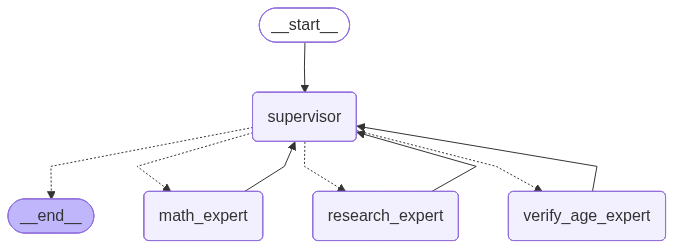

In [29]:
app

In [97]:
result["messages"][-1].content
result

{'messages': [HumanMessage(content='verify if ram is 40 years old', additional_kwargs={}, response_metadata={}, id='09b2efb3-fc5c-4eb9-bca7-e17feb66ec7c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_find_age_expert', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, name='supervisor', id='lc_run--4c91f439-6ad0-4969-a65f-c579411696bb-0', tool_calls=[{'name': 'transfer_to_find_age_expert', 'args': {}, 'id': '37e07d28-ca75-4a76-9dab-9c12fd755625', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 78, 'total_tokens': 240, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 62}}),
  ToolMessage(content='Successfully transferred to find_age_expert', name='transfer_to_find_age_expert', id='2676e209-ce7d-4daa-8

### Supervisor Agent with low level agent

In [22]:
from typing import Literal


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode

# --- Weather tool ---
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

# We'll create a model and bind the tool so the LLM knows it can call `get_weather`.
tools = [get_weather]
model = ChatGoogleGenerativeAI(
    model= "gemini-2.0-flash-exp",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)
# --- Existing agent workflow definition ---
def call_model(state: MessagesState):
    """Call the LLM with the conversation so far."""
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", END]:
    """If there's a tool call requested, go to 'tools', else end."""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

weather_workflow = StateGraph(MessagesState)

tool_node = ToolNode(tools)

weather_workflow.add_node("agent", call_model)
weather_workflow.add_node("tools", tool_node)

weather_workflow.add_edge(START, "agent")
weather_workflow.add_conditional_edges("agent", should_continue)
weather_workflow.add_edge("tools", "agent")

weather_agent_graph =  weather_workflow.compile(name="weather_agent")

In [23]:
from langgraph_supervisor import create_supervisor

supervisor_workflow = create_supervisor(
    agents=[weather_agent_graph],
    model=model,
    prompt=(
        "You are a supervisor managing a weather agent. "
        "For any weather-related question, call the 'weather_agent' to handle it."
    ),
    output_mode="last_message",
    #output_mode="full_history",
    supervisor_name="supervisor_agent",
)

supervisor_app = supervisor_workflow.compile()

In [24]:
supervisor_app.invoke(
    {"messages": [HumanMessage(content="Hello there, how are you?")]}
)

{'messages': [HumanMessage(content='Hello there, how are you?', additional_kwargs={}, response_metadata={}, id='89592459-4252-4496-974c-997e52162343'),
  AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-exp', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, name='supervisor_agent', id='lc_run--27744dea-d7b1-4a81-a996-3adb80024762-0', usage_metadata={'input_tokens': 50, 'output_tokens': 18, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}})]}

In [25]:
supervisor_app.invoke(
    {"messages": [HumanMessage(content="How is the weather in Munich?")]}
)


{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='bb509175-dd45-4ec7-bf08-8523240a5cd5'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_weather_agent', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-exp', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, name='supervisor_agent', id='lc_run--7ae3e2bc-56ab-47ed-94f4-b6badff5357f-0', tool_calls=[{'name': 'transfer_to_weather_agent', 'args': {}, 'id': 'e9c0bac4-2966-4075-a1cc-85a3d6ae885f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 7, 'total_tokens': 57, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Successfully transferred to weather_agent', name='transfer_to_weather_agent', id='6eb38d69-8523-46d0-9ff6-2b68af28522a', tool_call_id='e9c0bac4-29